<a target="_blank" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/065_loc_scale.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

(loc-scale-notebook)=
# Indici di posizione e di scala

La visualizzazione grafica dei dati rappresenta il pilastro fondamentale di ogni analisi quantitativa. Grazie alle rappresentazioni grafiche adeguate, è possibile individuare importanti caratteristiche di una distribuzione, quali la simmetria o l'asimmetria, nonché la presenza di una o più mode. Successivamente, al fine di descrivere sinteticamente le principali caratteristiche dei dati, si rende necessario l'utilizzo di specifici indici numerici. In questo capitolo, verranno presentati i principali indicatori della statistica descrittiva.

## Indici di tendenza centrale

Tra le misure utilizzate per indicare il valore centrale di un insieme di dati, la più diffusa è la media aritmetica. Essa fornisce informazioni riguardo ai valori intorno ai quali i dati del campione sono concentrati.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import scipy.stats as st
import arviz as az
from scipy.constants import golden

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

Per un’introduzione “soft” alla nozione di tendenza centrale di una
distribuzione statistica si segua il
[link](https://tinystats.github.io/teacups-giraffes-and-statistics/03_mean.html).

### Media

La media aritmetica di un insieme di valori ${x_1, x_2, \dots, x_n}$ è il valore medio ottenuto dalla somma di tutti i valori divisa per il numero totale di valori:

$$
\bar{x}=\frac{1}{n}\sum_{i=1}^n x_i.
$$ (eq-mean)

Questa formula è comunemente utilizzata in statistica per calcolare il valore centrale di un insieme di dati. Per esempio, se abbiamo i valori $3, 5, 7, 10$ e vogliamo calcolare la media, possiamo utilizzare la formula sopra riportata:

$$
\bar{x}=\frac{1}{4} (3+5+7+10) = \frac{25}{4}.
$$

La media ha una proprietà importante, ovvero la somma degli scarti tra ciascun valore $x_i$ e la media aritmetica $\bar{x}$ è uguale a zero, cioè:

$$
\sum_{i=1}^n (x_i - \bar{x}) = 0.\notag
$$ (eq-diffmeansumzero)

Infatti,

$$
\begin{aligned}
\sum_{i=1}^n (x_i - \bar{x}) &= \sum_i x_i - \sum_i \bar{x}\notag\\
&= \sum_i x_i - n \bar{x}\notag\\
&= \sum_i x_i - \sum_i x_i = 0.\notag
\end{aligned}
$$

Questa proprietà implica che la media aritmetica rappresenta un valore attorno al quale i dati sono equamente distribuiti in positivo e in negativo rispetto alla media stessa.

Un’altra proprietà della media è la seguente: la somma dei quadrati degli scarti tra ciascuna modalità $x_i$ e una costante arbitraria $a$, cioè $\varphi(a) = \sum_{i=1}^n (x_i - a)^2$, è minima per $a = \bar{x}$.

La definizione di media aritmetica ha spesso ispirato battute ironiche, come ad esempio la constatazione che in media ogni persona ha meno di due gambe o che ha un solo testicolo. Tuttavia, la media presenta alcune limitazioni: non sempre rappresenta l'indice che meglio descrive la tendenza centrale della distribuzione, soprattutto in presenza di asimmetria o di valori anomali (outlier). In questi casi, è preferibile utilizzare la mediana o la media spuntata (vedi oltre).

Se abbiamo un piccolo numero di valori, possiamo calcolare la media in Python come su qualunque calcolatore. Supponiamo che i valori siano 12, 44, 21, 62, 24. La media è

In [1]:
(12 + 44 + 21 + 62 + 24) / 5

32.6

ovvero

In [6]:
x = np.array([12, 44, 21, 62, 24])
x

array([12, 44, 21, 62, 24])

In [7]:
np.mean(x)

32.6

Molto spesso però i nostri dati sono contenuti in file e inserire i dati manualmente non è fattibile. Per fare un esempio, poniamoci il problema di calcolare la media dei valori BDI-II separatamente per ciascuno dei due gruppi di soggetti esaminati da {cite:t}`zetsche_2019future`.

Iniziamo ad importare i dati, a selezionare le colonne appropriate, a eliminare i duplicati e a rimuovere il dato mancante (come abbiamo fatto in precedenza). Otteniamo così un DataFrame di 66 righe e 3 colonne.

In [9]:
df = pd.read_csv("data/data.mood.csv", index_col=0)
df = df[["esm_id", "group", "bdi"]]
df = df.drop_duplicates(keep="first")
df = df[pd.notnull(df["bdi"])]
df.shape


(66, 3)

Esaminiamo la numerosità di ciascun gruppo.

In [10]:
df.groupby("group").size()

group
ctl    36
mdd    30
dtype: int64

Creiamo uno stripplot per esaminare i dati grezzi.

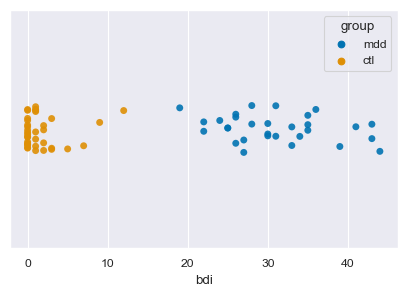

In [11]:
_ = sns.stripplot(x="bdi", data=df, jitter=0.1, hue="group", alpha=0.9)

Calcoliamo ora le medie dei valori BDI-II nei due gruppi. La funzione `round(2)` semplifica la risposta stampando solo 2 valori decimali.

In [7]:
df.groupby("group")["bdi"].mean().round(2)

group
ctl     1.61
mdd    30.93
Name: bdi, dtype: float64

In alternativa, possiamo usare il metodo `.describe()`:

In [8]:
df.groupby("group")["bdi"].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctl,36.0,1.6,2.7,0.0,0.0,1.0,2.0,12.0
mdd,30.0,30.9,6.6,19.0,26.0,30.0,35.0,44.0


### Media spuntata

La *media spuntata* $\bar{x}_t$ (o *trimmed mean*) è ottenuta calcolando la media dei dati dopo aver eliminato una determinata percentuale di dati estremi. In genere, si elimina il 10% dei dati, ovvero il 5% all'inizio e alla fine della distribuzione. Per ottenere la media spuntata, i dati vengono ordinati in modo crescente, $x_1 \leq x_2 \leq x_3 \leq \dots \leq x_n$, e poi viene eliminato il primo 5% e l'ultimo 5% dei dati nella sequenza ordinata. La media spuntata è quindi calcolata come la media aritmetica dei dati rimanenti. La media spuntata è utile quando ci sono valori anomali o quando la distribuzione è asimmetrica e la media aritmetica non è rappresentativa della tendenza centrale dei dati.

Per fare un esempio, calcoliamo la media spuntata dei valori BDI-II per i due gruppi di soggetti esaminati da {cite:t}`zetsche_2019future` escludendo il 10% dei valori più estremi. 

In [10]:
bdi_mdd = df[df["group"] == "mdd"].bdi
stats.trim_mean(bdi_mdd, 0.10)

30.625

In [11]:
bdi_ctl = df[df["group"] == "ctl"].bdi
stats.trim_mean(bdi_ctl, 0.10)

1.0

### Moda e mediana

In precedenza abbiamo già incontrato altri due popolari indici di
tendenza centrale: la *moda* (*Mo*), ovvero il valore centrale della
classe con la frequenza massima (può succedere che una distribuzione
abbia più mode; in tal caso si dice *multimodale* e questo operatore
perde il suo significato di indice di tendenza centrale) e la *mediana*
$\tilde{x}$.

Calcoliamo ora i quantili di ordine 0.10 e 0.90 dei valori BDI-II per
i due gruppi di {cite:t}`zetsche_2019future`.

In [12]:
# Create functions to calculate 0.10 and 0.90 quantiles
def q1(x):
    return x.quantile(0.10)


def q3(x):
    return x.quantile(0.90)


# Calculate quantiles by group
vals = {"bdi": [q1, q3]}
df.groupby("group").aggregate(vals)


bdi      
         q1    q3
group            
ctl     0.0   4.0
mdd    23.8  41.2

Si noti che solitamente i software restituiscono un valore *interpolato*
del $p$-esimo quantile $q_p$ $(0 < p < 1)$, il quale viene calcolato
mediante specifiche procedure. Il risultato fornito dai software,
dunque, non sarà identico a quello trovato utilizzando la definizione
non interpolata di quantile che abbiamo presentato in precedenza. Se,
per qualche ragione, vogliamo conoscere l’algoritmo usato per la
determinazione dei quantili interpolati, dobbiamo leggere la
documentazione del software.

### Quando usare media, moda, mediana

La moda può essere utilizzata per dati a livello nominale o ordinale, ed è l'unica tra le tre statistiche che può essere calcolata in questi casi.
La media è una buona misura di tendenza centrale solo se la distribuzione dei dati è simmetrica, ovvero se i valori sono distribuiti uniformemente a sinistra e a destra della media. Tuttavia, se ci sono valori anomali o se la distribuzione è asimmetrica, la media può essere influenzata in modo significativo, e quindi potrebbe non essere la scelta migliore come misura di tendenza centrale.
In questi casi, la mediana può fornire una misura migliore di tendenza centrale rispetto alla media, poiché la mediana è meno influenzata dai valori anomali e si basa esclusivamente sul valore centrale dell'insieme di dati. Pertanto, la scelta tra media e mediana dipende dal tipo di distribuzione dei dati e dallo scopo dell'analisi.

## Indici di dispersione

Le misure di posizione descritte in precedenza come le medie e gli indici di posizione, forniscono una sintesi dei dati che mettono in evidenza la tendenza centrale delle osservazioni. Tuttavia, non tengono conto di un aspetto importante della distribuzione dei dati, ovvero la variabilità dei valori numerici della variabile statistica. Pertanto, è necessario sintetizzare la distribuzione di una variabile statistica anche tramite l'utilizzo di indicatori che valutino la dispersione delle unità statistiche.

Per un’introduzione “soft” al tema degli indici di dispersione si segua
il
[link](https://tinystats.github.io/teacups-giraffes-and-statistics/04_variance.html).

### Indici basati sull’ordinamento dei dati

Per valutare la variabilità dei dati è possibile utilizzare indici basati sull'ordinamento dei dati. L'indice più ovvio è l'intervallo di variazione, che corrisponde alla differenza tra il valore massimo e il valore minimo di una distribuzione di modalità. Tuttavia, questo indice presenta il limite di essere calcolato sulla base di soli due valori della distribuzione, e non tiene conto di tutte le informazioni disponibili. Inoltre, l'intervallo di variazione può essere pesantemente influenzato dalla presenza di valori anomali. Un altro indice basato sull'ordinamento dei dati è la differenza interquartile, già incontrata in precedenza. Anche se questo indice utilizza più informazioni rispetto all'intervallo di variazione, presenta comunque il limite di essere calcolato sulla base di soli due valori della distribuzione ($x_{0.25}$ e $x_{0.75}$). Per valutare la variabilità in modo più completo, è necessario utilizzare altri indici di variabilità che tengano conto di tutti i dati disponibili.

### Varianza

Data la limitazione delle statistiche descritte in precedenza, è più comune utilizzare una misura di variabilità che tenga conto della dispersione dei dati intorno ad un indice di tendenza centrale. La varianza è la misura di variabilità più utilizzata per valutare la variabilità di una variabile statistica. Essa è definita come la media dei quadrati degli scarti $x_i - \bar{x}$ tra ogni valore e la media della distribuzione, come segue:

$$
\begin{equation}
S^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2.
\end{equation}
$$ (eq-var-descr)

La varianza è una misura di dispersione più complessa rispetto a quelle descritte in precedenza. Essa è appropriata solo nel caso di distribuzioni simmetriche e, come le altre misure di dispersione, è fortemente influenzata dai valori anomali. Inoltre, la varianza è espressa in un'unità di misura che è il quadrato dell'unità di misura dei dati originari e, pertanto, non può essere interpretata in modo intuitivo.

Calcoliamo la varianza dei valori BDI-II per i dati di {cite:t}`zetsche_2019future`. Applicando l'eq. {eq}`eq-var-descr`, per tutto il campione abbiamo

In [27]:
sum((df["bdi"] - np.mean(df["bdi"])) ** 2) / len(df["bdi"])

236.23875114784224

Più semplicemente, possiamo usare la funzione `np.var()`:

In [29]:
np.var(df["bdi"])

236.23875114784207

#### Stima della varianza della popolazione

Si noti il denominatore della formula della varianza. Nell'eq.{eq}`eq-var-descr`
ho usato $n$ (l’ampiezza campionaria, ovvero il numero di osservazioni
del campione). In questo modo ottengo la varianza quale *statistica
descrittiva* del campione. In alternativa, è possibile usare $n-1$ al
denominatore:

$$
\begin{equation}
s^2 = \frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})^2
\end{equation}
$$ (eq-var-stimatore)

In questo secondo modo si trova la varianza quale *stimatore* della
varianza della popolazione. Si può dimostrare che l'eq.{eq}`eq-var-stimatore`
fornisce una stima corretta (ovvero, non distorta) della varianza della
popolazione da cui abbiamo ottenuto il campione, mentre invece l'eq.{eq}`eq-var-descr` fornisce (in media) una stima troppo piccola della
varianza della popolazione. Si presti attenzione alla notazione: $S^2$
per la varianza quale statistica descrittiva, $s^2$ per la varianza
quale stimatore.

Per illustrare questo punto svolgiamo una simulazione. Consideriamo qui la distribuzione dei punteggi del quoziente di intelligenza (QI). I valori del QI seguono una particolare distribuzione chiamata *distribuzione normale* di media 100 e deviazione standard 15. La forma di questa distribuzione è illustrata nella figura seguente.

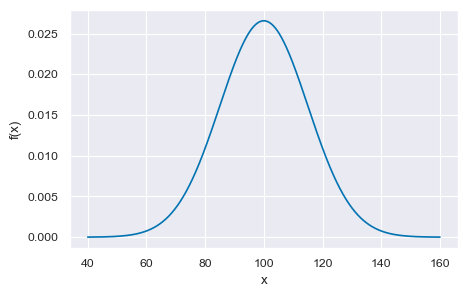

In [3]:
x = np.arange(100 - 4 * 15, 100 + 4 * 15, 0.001)

mu = 100
sigma = 15

pdf = st.norm.pdf(x, mu, sigma)
plt.plot(x, pdf)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


Supponiamo di estrarre un campione casuale di 4 osservazioni dalla popolazione del quoziente di intelligenza -- in altre parole, supponiamo di misurare il quoziente di intelligenza di 4 persone prese a caso dalla popolazione.

In [6]:
x = rng.normal(loc=100, scale=15, size=4)
print(x)

[ 98.86985039  88.88673022  79.48310947 109.73339203]


Calcoliamo la varianza usando $n$ al denominatore. Si noti che la vera varianza del quoziente di intelligenza è $15^2$ = 225.

In [7]:
np.var(x)

126.97599598691752

Consideriamo ora 10 campioni casuali del QI, ciascuno di ampiezza 4.

In [31]:
mu = 100
sigma = 15
size = 4
niter = 10
random_samples = []

for i in range(niter):
    one_sample = rng.normal(loc=mu, scale=sigma, size=size)
    random_samples.append(one_sample)

Il primo campione è

In [15]:
random_samples[0]

array([ 78.64262445, 118.95592687,  86.94007393,  96.11240148])

Il decimo campione è

In [ ]:
random_samples[9]

Stampiamo i valori di tutti i 10 campioni.

In [16]:
rs = np.array(random_samples)
rs

array([[ 78.64262445, 118.95592687,  86.94007393,  96.11240148],
       [ 98.86985039,  88.88673022,  79.48310947, 109.73339203],
       [105.4158717 ,  70.70705405, 135.21114482, 114.52745359],
       [ 88.60919229, 113.53297411,  92.9957024 ,  99.08965722],
       [111.83266517,  81.149978  , 108.63786272, 120.98468492],
       [119.83447091,  95.50452227, 113.54379012,  75.67625899],
       [ 97.62716109, 106.74225898,  79.84598391,  98.77468614],
       [125.87109898, 139.2723914 , 111.66042016, 112.42949793],
       [ 85.6151753 ,  81.8591757 ,  78.8156198 , 108.12320245],
       [111.27909093,  90.11859521,  81.56987522, 103.86336653]])

Per ciascun campione (ovvero, per ciascuna riga della matrice
precedente), calcoliamo la varianza usando la formula con $n$ al denominatore.
Otteniamo così 10 stime della varianza della popolazione del QI.

In [17]:
x_var = np.var(rs, axis=1)  # applichiamo la funzione su ciascuna riga
print(x_var)

[226.88601335 126.97599599 542.76884186  88.61260836 220.63907623
 295.87449185  96.60998017 127.86050222 132.80934429 134.02475959]


Notiamo due cose: 

- le stime sono molto diverse tra loro; questo fenomeno è noto con il nome di *variabilità campionaria*;
- in media le stime sembrano troppo piccole.

Per aumentare la sicurezza riguardo al secondo punto menzionato in precedenza, ripeteremo la simulazione utilizzando un numero di iterazioni maggiore.

In [33]:
mu = 100
sigma = 15
size = 4
niter = 10000
random_samples = []

for i in range(niter):
    one_sample = rng.normal(loc=mu, scale=sigma, size=size)
    random_samples.append(one_sample)

rs = np.array(random_samples)
x_var = np.var(rs, axis=1)

Esaminiamo la distribuzione dei valori ottenuti.

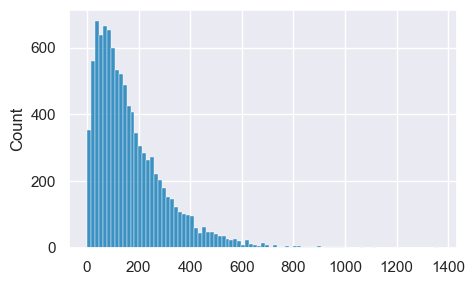

In [34]:
_ = sns.histplot(x_var)

La stima più verosimile della varianza del QI è dato dalla media di
questa distribuzione.

In [35]:
np.mean(x_var)

168.30207939405307

Si noti che il nostro spospetto è stato confermato: il valore medio della stima della varianza ottenuta con l'eq.{eq}`eq-var-descr` è troppo piccolo rispetto al valore corretto di $15^2 = 225$. 

Ripetiamo ora la simulazione usando la formula della varianza con $n-1$ al denominatore.

In [50]:
mu = 100
sigma = 15
size = 4
niter = 10000
random_samples = []

for i in range(niter):
    one_sample = rng.normal(loc=mu, scale=sigma, size=size)
    random_samples.append(one_sample)

rs = np.array(random_samples)
x_var = np.var(rs, ddof=1, axis=1)

np.mean(x_var)

222.76145265731117

Nel secondo caso, se si utilizza $n-1$ come denominatore per calcolare la stima della varianza, il valore atteso di questa stima è molto vicino al valore corretto di 225. Se il numero di campioni fosse stato infinito, i due valori sarebbero stati identici.

In conclusione, le due formule della varianza hanno scopi diversi. La formula della varianza con $n$ al denominatore viene utilizzata come statistica descrittiva per descrivere la variabilità di un particolare campione di osservazioni. Al contrario, la formula della varianza con $n-1$ al denominatore viene utilizzata come stimatore per ottenere la migliore stima della varianza della popolazione da cui quel campione è stato estratto.

### Precisione

La *precisione* è definita come l'inverso della varianza:

$$
\tau = \frac{1}{\sigma^2}.
$$ (eq-precision)

Gli esperti ritengono che la precisione sia una misura più "intuitiva" della varianza, in quanto indica quanto i valori sono concentrati attorno alla media, piuttosto che quanto sono dispersi. In altre parole, la precisione è un'indicazione di quanto le misurazioni siano accurate. Se i valori sono molto dispersi attorno alla media (alta varianza), la precisione è bassa (poca accuratezza); se invece la varianza è bassa, la precisione è alta.

La precisione è uno dei due parametri naturali della distribuzione normale, insieme alla media. Nei termini dell'eq. {eq}`eq-precision`, la distribuzione normale
(si veda il Capitolo {ref}`cont-rv-distr-notebook`) può essere espressa nel modo seguente

$$
{\displaystyle f(y)=\sqrt{\frac{\tau}{2\pi}} e^{-{\frac {1}{2}}\tau\left({y-\mu }\right)^{2}}},
$$

anziché come

$$
{\displaystyle f(y)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {y-\mu }{\sigma }}\right)^{2}}}.
$$

### Deviazione standard

Per interpretare la varianza in modo più intuitivo, si può calcolare la deviazione standard (o scarto quadratico medio o scarto tipo) prendendo la radice quadrata della varianza. La deviazione standard è espressa nell'unità di misura originaria dei dati, a differenza della varianza che è espressa nel quadrato dell'unità di misura dei dati. La deviazione standard fornisce una misura della dispersione dei dati attorno alla media, rendendo più facile la comprensione della variabilità dei dati. La *deviazione standard* (o *scarto quadratico medio*, o *scarto tipo*)[1] è definita come:

$$
s^2 = \sqrt{(n-1)^{-1} \sum_{i=1}^n (x_i - \bar{x})^2}
$$ (eq-sd-stimatore)

Quando tutte le osservazioni sono uguali, $s = 0$, altrimenti $s > 0$.

```{admonition} Nota
Il termine *standard deviation* è stato introdotto in statistica da Pearson nel 1894 assieme alla lettera greca $\sigma$ che lo rappresenta. Il termine italiano "deviazione standard" ne è la traduzione più utilizzata nel linguaggio comune; il termine dell’[Ente Nazionale Italiano di Unificazione](https://it.wikipedia.org/wiki/Ente_nazionale_italiano_di_unificazione)
è tuttavia “scarto tipo”, definito come la radice quadrata positiva della varianza.
```

La deviazione standard $s$ dovrebbe essere utilizzata solo quando la media è una misura appropriata per descrivere il centro della distribuzione, ad esempio nel caso di distribuzioni simmetriche. Come la media $\bar{x}$, infatti, anche la deviazione standard è fortemente influenzata dalla presenza di dati anomali, ovvero pochi valori che si discostano notevolmente dalla media rispetto agli altri dati della distribuzione.

Per fare un esempio, calcoliamo la deviazione standard per i valori BDI-II del campione di
{cite:t}`zetsche_2019future`.

Applicando l'eq. {eq}`eq-sd-stimatore`, per tutto il campione abbiamo

In [51]:
np.std(df.bdi)

15.370060219395436

Per ciascun gruppo, abbiamo:

In [52]:
df.groupby("group")["bdi"].std()

group
ctl    2.707427
mdd    6.606858
Name: bdi, dtype: float64

#### Interpretazione

La deviazione standard può essere interpretata in modo semplice: essa è simile allo scarto semplice medio campionario, cioè alla media aritmetica dei valori assoluti degli scarti dalla media, anche se non identica. La deviazione standard ci fornisce quindi un'indicazione di quanto le singole osservazioni si discostino, in media, dal centro della distribuzione. Una spiegazione più accurata del significato della deviazione standard sarà fornita nel paragrafo successivo.

Si verifichi l’interpretazione della deviazione standard fornita sopra
usando i valori BDI-II del campione di {cite:t}`zetsche_2019future`.

Per questi dati la deviazione standard è

In [53]:
np.std(df.bdi)

15.370060219395436

Lo scarto semplice medio campionario è

### Deviazione mediana assoluta

Una misura robusta della dispersione statistica di un campione è la
*deviazione mediana assoluta* (*Median Absolute Deviation*, MAD)
definita come la mediana del valore assoluto delle deviazioni dei dati
dalla mediana, ovvero:

$$
{\displaystyle \operatorname {MAD} =\operatorname {median} \left(\ \left|X_{i}-\operatorname {median} (X)\right|\ \right)}
$$ (eq-mad-def)

Nel caso di una distribuzione dei dati unimodale simmetrica di forma
campanulare (ovvero, normale) si ha che

$$
{\displaystyle \text{deviazione standard} \approx 1.4826\ \operatorname {MAD} .\,}
$$

Pertanto, solitamente i software restituiscono il valore MAD
moltiplicato per una tale costante.

I dati di {cite:t}`zetsche_2019future` seguono una distribuzione bimodale, per cui
il vincolo precedente non si applica. Verifichiamo dunque il principio
precedente usando un campione di dati estratto da una popolazione
normale. Usiamo, ad esempio, la distribuzione $\mathcal{N}(100, 15)$:

In [54]:
np.mean(np.abs(df.bdi - np.mean(df.bdi)))

14.539944903581269

In [56]:
x = np.random.normal(loc=100, scale=15, size=10000)
1.4826 * np.median(np.abs(x - np.median(x)))

14.944719064806087

### Quando usare la deviazione standard e MAD

La deviazione standard e la MAD sono entrambe misure di dispersione che indicano quanto i dati in un insieme si discostano dalla tendenza centrale. Tuttavia, ci sono alcune differenze tra le due misure e situazioni in cui può essere più appropriato utilizzare una rispetto all'altra.

- Deviazione standard: la deviazione standard è particolarmente utile per descrivere la dispersione dei dati in una distribuzione normale. In generale, la deviazione standard è una buona scelta se si vuole sapere quanto i dati sono distribuiti intorno alla media, o se si vuole confrontare la dispersione di due o più set di dati.
- Deviazione mediana assoluta (MAD): la MAD è meno sensibile ai valori anomali rispetto alla deviazione standard, il che la rende una scelta migliore quando ci sono valori anomali nell'insieme di dati. Inoltre, la MAD può essere una buona scelta quando si utilizzano dati non normalmente distribuiti.

In sintesi, se si lavora con dati normalmente distribuiti, la deviazione standard è la misura di dispersione più appropriata. Se si lavora con dati non normalmente distribuiti o si hanno valori anomali nell'insieme di dati, la MAD può essere una scelta migliore. In ogni caso, la scelta tra le due misure dipende dal tipo di dati che si sta analizzando e dall'obiettivo dell'analisi.

### Indici di variabilità relativi

A volte può essere interessante effettuare un confronto fra due misure
di variabilità di grandezze incommensurabili, ovvero di caratteri
rilevati mediante differenti unità di misura. In questi casi, le misure
di variabilità precedentemente descritte si rivelano inadeguate in
quanto dipendono dall’unità di misura adottata. Diventa dunque
necessario ricorrere a particolari numeri adimensionali detti *indici
relativi di variabilità*. Il più importante di tali indici è il
*coefficiente di variazione*, ovvero il numero puro

$$
C_v = \frac{\sigma}{\bar{x}}
$$ (eq-cv-def)

ottenuto dal rapporto tra la deviazione standard e la media dei dati.

Un altro indice relativo di variabilità è la differenza interquartile
rapportata al primo quartile, oppure al terzo quartile, oppure alla
mediana, cioè:

$$
\frac{x_{0.75} - x_{0.25}}{x_{0.25}}, \qquad \frac{x_{0.75} - x_{0.25}}{x_{0.75}}, \qquad \frac{x_{0.75} - x_{0.25}}{x_{0.50}}.
$$

## Commenti e considerazioni finali

Le statistiche descrittive consentono di ottenere degli indici sintetici che riassumono i dati, sia per l'intera popolazione che per un campione estratto da essa. Questi indici includono le misure di tendenza centrale, come la media, la mediana e la moda, che indicano la posizione centrale dei dati. Inoltre, ci sono anche gli indici di dispersione, come la deviazione standard e la varianza, che indicano quanto i dati sono distribuiti attorno alla tendenza centrale. È importante notare che la curtosi e l'asimmetria sono indici di dispersione che si applicano solo alle distribuzioni normali e verranno approfonditi in quel contesto.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w 